In [1]:
import torch
from transformers import AutoTokenizer
from unsloth import FastLanguageModel
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from functools import partial
import random
import gc

/data/common/ethanchang/ucct/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1421045/736639057.py:3: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# --- PART 1: DATA GENERATION (No changes needed) ---

def to_base(n, base):
    if n == 0: return "0"
    digits = []
    while n: digits.append(str(n % base)); n //= base
    return "".join(digits[::-1])

def generate_arithmetic_data(base, num_digits, num_samples):
    data = []
    max_val = base**num_digits
    for _ in range(num_samples):
        n1, n2 = random.randint(0, max_val - 1), random.randint(0, max_val - 1)
        s = n1 + n2
        n1_base, n2_base, s_base = to_base(n1, base), to_base(n2, base), to_base(s, base)
        problem = f"{n1_base}+{n2_base}"
        cot_steps = [f"Step 1: The problem is {problem}.", f"Step 2: The answer is {s_base}."] # Simplified CoT for example
        cot_trace = "\n".join(cot_steps)
        data.append({"problem": problem, "answer": s_base, "cot": cot_trace})
    return data

In [23]:
class GeometricAnalyzer:
    """Uses hooks to analyze the internal geometry of a model and can perform
    a sanity-check decoding of a hidden state from a specified layer."""
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.outputs = {}
        self.hook_handles = []

    def _get_hook(self, layer_idx):
        def hook(module, input, output):
            self.outputs[layer_idx] = output[0].detach().cpu()
        return hook

    def _decode_vector_to_text(self, vector, top_k=5):
        """Decodes a hidden state vector into its top k most likely tokens."""
        # Ensure vector is on the correct device
        vector = vector.to(self.model.device).to(torch.bfloat16)

        # Pass through final normalization and LM head
        with torch.no_grad():
            normalized_vector = self.model.model.norm(vector)
            logits = self.model.lm_head(normalized_vector)

        # Get top k token predictions
        top_k_logits, top_k_indices = torch.topk(logits.to(torch.float32), top_k)
        top_k_tokens = self.tokenizer.convert_ids_to_tokens(top_k_indices.cpu().numpy())
        
        return list(zip(top_k_tokens, top_k_logits.cpu().numpy()))

    def analyze(self, instruction, examples, layers_to_probe, sanity_check_layer=None):
        self.outputs.clear()
        prompt_parts, separator = [instruction] + examples, "\n\n"
        full_prompt_text = separator.join(prompt_parts)
        inputs = self.tokenizer(full_prompt_text, return_tensors="pt").to(self.model.device)
        end_indices, current_offset = [], 0
        for part in prompt_parts:
            part_tokens = self.tokenizer(part, add_special_tokens=False)['input_ids']
            end_indices.append(current_offset + len(part_tokens) - 1)
            separator_tokens = self.tokenizer(separator, add_special_tokens=False)['input_ids']
            current_offset += len(part_tokens) + len(separator_tokens)
        
        for i in layers_to_probe:
            handle = self.model.model.layers[i].register_forward_hook(self._get_hook(i))
            self.hook_handles.append(handle)
        
        with torch.no_grad(): self.model(**inputs)
        
        for handle in self.hook_handles: handle.remove()
        self.hook_handles.clear()

        # ... (The rho_d and d_r calculation loop remains the same) ...
        results = {}
        for i in layers_to_probe:
            hidden_states = self.outputs[i]
            instruction_end_idx = end_indices[0]
            example_end_indices = end_indices[1:]
            task_vec = hidden_states[0, instruction_end_idx, :]
            example_vecs = hidden_states[0, example_end_indices, :]
            if len(example_vecs) > 1:
                example_vecs = example_vecs.to(torch.float32)
                rho_d = 1 / (torch.mean(torch.pdist(example_vecs)) + 1e-6)
            else: rho_d = 0.0
            centroid = torch.mean(example_vecs, dim=0)
            d_r = 1 - torch.nn.functional.cosine_similarity(task_vec, centroid, dim=0)
            results[i] = {"rho_d": rho_d.item(), "d_r": d_r.item()}

        # --- <<< NEW SANITY CHECK BLOCK >>> ---
        if sanity_check_layer is not None and sanity_check_layer in self.outputs:
            print("\n" + "-"*20 + f" SANITY CHECK @ LAYER {sanity_check_layer} " + "-"*20)
            
            # Get the hidden state for the instruction from the sweet spot layer
            hidden_states = self.outputs[sanity_check_layer]
            instruction_end_idx = end_indices[0]
            task_vec_at_sweet_spot = hidden_states[0, instruction_end_idx, :]

            # Decode the vector
            decoded_tokens = self._decode_vector_to_text(task_vec_at_sweet_spot)
            
            print(f"Top 5 predicted tokens for the instruction vector ('...{instruction[-20:]}'):")
            for token, logit in decoded_tokens:
                print(f"  - '{token}' (Logit: {logit:.2f})")
            print("-" * (54 + len(str(sanity_check_layer))))

        return results

In [3]:
# --- PART 3: EVALUATION MODULE (No changes needed, it's compatible) ---

def parse_model_output(output_text):
    match = re.search(r'(\d+)\s*$', output_text.strip())
    return match.group(1) if match else ""

def evaluate_accuracy(model, tokenizer, test_set, anchor_prompt=""):
    correct, total = 0, len(test_set)
    for item in tqdm(test_set, desc="Evaluating Accuracy", leave=False):
        prompt = anchor_prompt + f"Problem: {item['problem']}\nAnswer: "
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id, use_cache=True)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
        if parse_model_output(response) == item['answer']: correct += 1
    return correct / total if total > 0 else 0

# Setup

In [4]:
print("--- Setting up Model and Tokenizer with Unsloth ---")
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
max_seq_length = 2048 # Recommended to set for Unsloth

# <<< UNLOTH CHANGE >>>
# Use FastLanguageModel for 2x faster loading, 50% less VRAM, and 2x faster inference.
model, tokenizer = FastLanguageModel.from_pretrained(
	model_name = model_id,
	max_seq_length = max_seq_length,
	dtype = torch.bfloat16,
	load_in_4bit = True,
)
# The tokenizer is already configured by Unsloth, including the pad token.

# --- Data Generation ---
print("\n--- Generating Datasets ---")
bases = [8, 9, 10]
datasets = {}
for base in bases:
	print(f"Generating data for Base {base}...")
	datasets[base] = {"train_2d": generate_arithmetic_data(base, 2, 1000), "test_2d_id": generate_arithmetic_data(base, 2, 250),
						"test_3d_ood": generate_arithmetic_data(base, 3, 250), "test_4d_ood": generate_arithmetic_data(base, 4, 250)}

--- Setting up Model and Tokenizer with Unsloth ---
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 8. Max memory: 47.408 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

--- Generating Datasets ---
Generating data for Base 8...
Generating data for Base 9...
Generating data for Base 10...


# Experiments

In [13]:
# --- EXPERIMENT CONFIGURATION ---
NUM_RUNS = 5  # <<< Number of times to repeat the experiment
ICL_K_VALUES = [0, 1, 2, 4, 8, 16] # k-shots for ICL evaluation
GEOMETRIC_ANALYSIS_K = 8 # Number of examples for geometric analysis
ICL_EVAL_SUBSET_SIZE = 30 # Use a subset of test data for faster ICL eval

all_runs_geometric_results = {base: [] for base in bases}
all_runs_icl_results = {base: {"standard": [], "cot": []} for base in bases}


In [24]:
# --- Experiment 1a: Geometric Analysis
for run_idx in range(NUM_RUNS):
	print(f"\n{'='*20} STARTING RUN {run_idx + 1}/{NUM_RUNS} {'='*20}")
	gc.collect(); torch.cuda.empty_cache() # Clear memory between runs
	
	# --- Experiment 1: Geometric Analysis ---
	print("\n--- Experiment 1: Geometric Analysis ---")
	analyzer = GeometricAnalyzer(model, tokenizer)
	num_layers = model.config.num_hidden_layers
	layers_to_probe = list(range(num_layers))

	for base in bases:
		print(f"\n{'='*50}\nAnalyzing geometry for Base {base} (Run {run_idx + 1})\n{'='*50}")
		instruction = f"Perform addition in base {base}."
		sampled_examples = random.sample(datasets[base]['train_2d'], GEOMETRIC_ANALYSIS_K)
		examples = [f"{item['problem']} -> {item['answer']}" for item in sampled_examples]
		
		SWEET_SPOT_LAYER = 28 
		run_geometry = analyzer.analyze(instruction, examples, layers_to_probe, sanity_check_layer=SWEET_SPOT_LAYER)
		
		all_runs_geometric_results[base].append(run_geometry)
  
		# # --- ADDED: Sanity Check Generation Step ---
		# print("\n[Sanity Check] Testing model response to the full prompt...")
		
		# # Grab a test problem that the model hasn't seen in the examples
		# test_item = datasets[base]['test_2d_id'][0]
		# test_problem_str = f"{test_item['problem']} ->"
		
		# # Construct the full prompt, just as the model would see it for ICL
		# separator = "\n\n"
		# sanity_check_prompt = separator.join([instruction] + examples + [test_problem_str])
		
		# # Tokenize and generate
		# inputs = tokenizer(sanity_check_prompt, return_tensors="pt").to(model.device)
		# with torch.no_grad():
		# 	outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id, use_cache=True)
		
		# # Decode and print
		# generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)


==================== STARTING RUN 1/5 ====================

--- Experiment 1: Geometric Analysis ---

Analyzing geometry for Base 8 (Run 1)

-------------------- SANITY CHECK @ LAYER 28 --------------------
Top 5 predicted tokens for the instruction vector ('... addition in base 8.'):
  - 'Ġoct' (Logit: 19.62)
  - 'ĠOct' (Logit: 18.50)
  - 'Oct' (Logit: 15.31)
  - '/oct' (Logit: 13.50)
  - 'oct' (Logit: 13.31)
--------------------------------------------------------

Analyzing geometry for Base 9 (Run 1)

-------------------- SANITY CHECK @ LAYER 28 --------------------
Top 5 predicted tokens for the instruction vector ('... addition in base 9.'):
  - 'Ġinstead' (Logit: 6.78)
  - 'ĠHexatrigesimal' (Logit: 6.59)
  - 'Ġrepresentations' (Logit: 6.31)
  - 'senal' (Logit: 6.31)
  - 'Ġnumeral' (Logit: 6.28)
--------------------------------------------------------

Analyzing geometry for Base 10 (Run 1)

-------------------- SANITY CHECK @ LAYER 28 --------------------
Top 5 predicted tokens

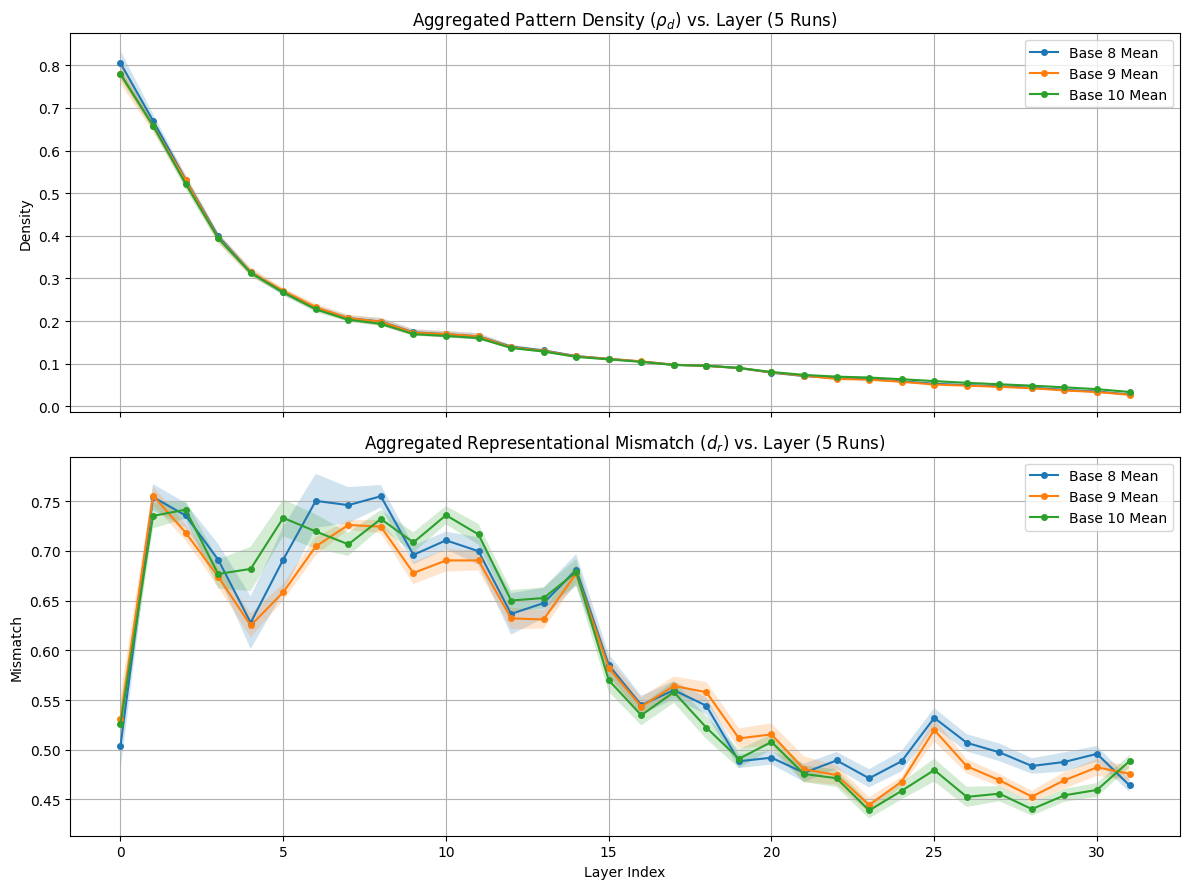

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
for base in bases:
	# Aggregate geometric data
	base_rho_d = np.array([[res[i]['rho_d'] for i in layers_to_probe] for res in all_runs_geometric_results[base]])
	base_d_r = np.array([[res[i]['d_r'] for i in layers_to_probe] for res in all_runs_geometric_results[base]])
	
	mean_rho_d, std_rho_d = np.mean(base_rho_d, axis=0), np.std(base_rho_d, axis=0)
	mean_d_r, std_d_r = np.mean(base_d_r, axis=0), np.std(base_d_r, axis=0)

	ax1.plot(layers_to_probe, mean_rho_d, marker='o', markersize=4, label=f'Base {base} Mean')
	ax1.fill_between(layers_to_probe, mean_rho_d - std_rho_d, mean_rho_d + std_rho_d, alpha=0.2)
	ax2.plot(layers_to_probe, mean_d_r, marker='o', markersize=4, label=f'Base {base} Mean')
	ax2.fill_between(layers_to_probe, mean_d_r - std_d_r, mean_d_r + std_d_r, alpha=0.2)

ax1.set_title(f'Aggregated Pattern Density ($\\rho_d$) vs. Layer ({NUM_RUNS} Runs)')
ax1.set_ylabel('Density'); ax1.grid(True); ax1.legend()
ax2.set_title(f'Aggregated Representational Mismatch ($d_r$) vs. Layer ({NUM_RUNS} Runs)')
ax2.set_ylabel('Mismatch'); ax2.set_xlabel('Layer Index'); ax2.grid(True); ax2.legend()
plt.tight_layout(); plt.show()

In [11]:
# --- Experiment 2: In-Context Learning Performance ---
print("\n--- Experiment 2: In-Context Learning (ICL) ---")
k_values = [0, 1, 2, 4, 8, 16, 32]
icl_results = {}

for base in bases:
	icl_results[base] = {"standard": [], "cot": []}
	for use_cot in [False, True]:
		cot_str = "CoT" if use_cot else "Standard"
		print(f"Running ICL for Base {base} ({cot_str})...")
		for k in k_values:
			# Build the k-shot anchor prompt
			anchor_prompt = ""
			if k > 0:
				for item in datasets[base]['train_2d'][:k]:
					if use_cot:
						anchor_prompt += f"Problem: {item['problem']}\nAnswer:\n{item['cot']}\n\n"
					else:
						anchor_prompt += f"Problem: {item['problem']}\nAnswer: {item['answer']}\n\n"
			
			# Evaluate on the 2-digit ID test set
			accuracy = evaluate_accuracy(model, tokenizer, datasets[base]['test_2d_id'][:50], anchor_prompt) # Using a subset for speed
			result_key = "cot" if use_cot else "standard"
			icl_results[base][result_key].append(accuracy)
			print(f"  k={k}, Accuracy={accuracy:.3f}")
   
# Plot ICL results
plt.figure(figsize=(10, 6))
for base in bases:
	plt.plot(k_values, icl_results[base]['standard'], marker='o', linestyle='-', label=f'Base {base} (Standard)')
	plt.plot(k_values, icl_results[base]['cot'], marker='s', linestyle='--', label=f'Base {base} (CoT)')
plt.title('ICL Accuracy vs. Number of Shots (k)')
plt.xlabel('Number of Shots (k)'); plt.ylabel('Accuracy'); plt.xscale('log', base=2); plt.xticks(k_values, k_values); plt.legend(); plt.grid(True); plt.show()



--- Experiment 2: In-Context Learning (ICL) ---
Running ICL for Base 8 (Standard)...


  k=0, Accuracy=0.000


  k=1, Accuracy=0.000


  k=2, Accuracy=0.000


  k=4, Accuracy=0.000


  k=8, Accuracy=0.000


  k=16, Accuracy=0.040


  k=32, Accuracy=0.020
Running ICL for Base 8 (CoT)...


  k=0, Accuracy=0.000


  k=1, Accuracy=0.000


  k=2, Accuracy=0.020


  k=4, Accuracy=0.000


  k=8, Accuracy=0.000


  k=16, Accuracy=0.000


  k=32, Accuracy=0.000
Running ICL for Base 9 (Standard)...


  k=0, Accuracy=0.000


  k=1, Accuracy=0.000


  k=2, Accuracy=0.000


  k=4, Accuracy=0.020


  k=8, Accuracy=0.000


  k=16, Accuracy=0.000


  k=32, Accuracy=0.000
Running ICL for Base 9 (CoT)...


  k=0, Accuracy=0.000


  k=1, Accuracy=0.000


  k=2, Accuracy=0.000


KeyboardInterrupt: 

In [ ]:
# --- Experiment 3: Supervised Fine-Tuning (SFT) ---
print("\n--- Experiment 3: Supervised Fine-Tuning (SFT) ---")
print("This section prepares the SFT but stubs out the training due to time/resource constraints.")

# LoRA Config
lora_config = LoraConfig(
	r=16,
	lora_alpha=32,
	target_modules=["q_proj", "v_proj"],
	lora_dropout=0.05,
	bias="none",
	task_type="CAUSAL_LM"
)

# In a real run, you would loop through bases and CoT/No-CoT configs,
# create a PEFT model, and use transformers.Trainer to train.
print("\nSFT Training would be performed here. Example:")
print("model_peft = get_peft_model(model, lora_config)")
print("trainer = transformers.Trainer(...)")
print("trainer.train()")
print("\nFor now, we will simulate the evaluation on the *base model* as a placeholder.")

sft_results = {}
for base in bases:
	print(f"\nEvaluating placeholder 'SFT-tuned' model for Base {base}")
	# In a real run, you'd load the trained adapter here:
	# tuned_model = PeftModel.from_pretrained(model, f'./sft-base-{base}')
	tuned_model = model # Using base model as placeholder
	
	sft_results[base] = {
		"ID_2d": evaluate_accuracy(tuned_model, tokenizer, datasets[base]['test_2d_id'][:50]),
		"OOD_3d": evaluate_accuracy(tuned_model, tokenizer, datasets[base]['test_3d_ood'][:50]),
		"OOD_4d": evaluate_accuracy(tuned_model, tokenizer, datasets[base]['test_4d_ood'][:50]),
	}
	# Cross-base OOD
	for other_base in bases:
		if other_base != base:
			sft_results[base][f"OOD_cross_base_{other_base}"] = evaluate_accuracy(
				tuned_model, tokenizer, datasets[other_base]['test_2d_id'][:50]
			)

print("\n--- SFT Placeholder Evaluation Results ---")
for base, results in sft_results.items():
	print(f"\nBase {base} Model Performance:")
	for test_name, acc in results.items():
		print(f"  {test_name}: {acc:.3f}")

In [ ]:
# --- FINAL ANALYSIS: Linking Geometry to Performance ---
print("\n--- Final Analysis: Linking Geometry to Performance ---")
# Let's find the 'sweet spot' layer from our geometric analysis
sweet_spot_layer = 25 # Based on previous findings

plt.figure(figsize=(8, 6))
for base in bases:
	# Get the geometric metric from the sweet spot
	initial_mismatch = geometric_results[base][sweet_spot_layer]['d_r']
	
	# Get a performance metric, e.g., accuracy at k=8
	k8_idx = k_values.index(8)
	k8_accuracy = icl_results[base]['standard'][k8_idx]
	
	plt.scatter(initial_mismatch, k8_accuracy, s=150, label=f'Base {base}', alpha=0.7)

plt.title('Performance vs. Initial Geometric Mismatch')
plt.xlabel(f'Initial Mismatch $d_r$ @ Layer {sweet_spot_layer}')
plt.ylabel('Standard ICL Accuracy @ k=8')
plt.grid(True); plt.legend(); plt.show()

print("\n--- CONCLUSION ---")
print("The final plot tests the core hypothesis: Does a lower initial geometric mismatch")
print("(meaning the task instruction is more naturally aligned with the examples in the model's latent space)")
print("correlate with better in-context learning performance? If the points form a downward trend,")
print("the hypothesis is supported.")